# Milestone 1

### TODO:
* extract 1-3 outcome variables
    * Feature engineering: often you may need to transform or generate your own outcome variable
    * If you have continuous income, often useful to generate binary outcome of high vs low income
* 5-10 predictor variables from the data
* identify important sub-groups (for example, by gender or by year) AND use them in sub-group analysis
* at least two descriptive statistics tables
    * one for all sample
    * one by group (e.g. 2017 vs. 2022; male vs. female; old vs. young; Allston-Brighton vs. Roxbury) 
* analytical plans and methods (a minimum of 2 methods presented in this course)

In [44]:
# Loading required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
import folium
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder


In [108]:
# Load your data
df = pd.read_csv('Crime Data 18+20+22.csv')

/var/folders/5y/pjrsw60n65124xb_fjnr_68m0000gn/T/ipykernel_63892/266777501.py:2: DtypeWarning: Columns (1,3,7,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Crime Data 18+20+22.csv')


In [109]:
df["DISTRICT"].replace('A1', 'Downtown & Charlestown', inplace=True)
df["DISTRICT"].replace('A15', 'Downtown & Charlestown', inplace=True)
df["DISTRICT"].replace('A7', 'East Boston', inplace=True)
df["DISTRICT"].replace('B2', 'Roxbury', inplace=True)
df["DISTRICT"].replace('B3', 'Mattapan', inplace=True)
df["DISTRICT"].replace('C6', 'South Boston', inplace=True)
df["DISTRICT"].replace('C11', 'Dorchester', inplace=True)
df["DISTRICT"].replace('D4', 'South End', inplace=True)
df["DISTRICT"].replace('D14', 'Brighton', inplace=True)
df["DISTRICT"].replace('E5', 'West Roxbury', inplace=True)
df["DISTRICT"].replace('E13', 'Jamaica Plain', inplace=True)
df["DISTRICT"].replace('E18', 'Hyde Park', inplace=True)
df["DISTRICT"].dropna(inplace=True)

In [74]:
# aggregation by DISTRICT and YEAR to count incidents
district_yearly_counts = df.groupby(['DISTRICT', 'YEAR']).size().unstack(fill_value=0)

# Calculate trend direction for each district
district_yearly_counts['Trend'] = district_yearly_counts.apply(
    lambda row: 'Upward' if row[2022] > row[2018] else 'Downward' if row[2022] < row[2018] else 'Stable', axis=1
)

# Identify the most common crime in each district
most_common_crime = df.groupby('DISTRICT')['OFFENSE_CODE_GROUP'].agg(lambda x: x.mode())

# Merge trend and most common crime information
trend_data = district_yearly_counts[['Trend']].merge(most_common_crime, left_index=True, right_index=True)
trend_data.columns = ['Trend', 'Most_Common_Crime']

# Initialize map centered on an average location
m = folium.Map(location=[df['Lat'].mean(), df['Long'].mean()], zoom_start=11)

# Add choropleth-style coloring for trends
for district, row in trend_data.iterrows():
    trend = row['Trend']
    common_crime = row['Most_Common_Crime']
    
    # Color by trend type
    if trend == 'Upward':
        color = 'red'
    elif trend == 'Downward':
        color = 'green'
    else:
        color = 'blue'
    
    # Assuming `district_coords` holds center coordinates for each district for demo purposes
    district_coords = [df[df['DISTRICT'] == district]['Lat'].mean(), 
                       df[df['DISTRICT'] == district]['Long'].mean()]
    
    # Add marker with trend and common crime
    folium.CircleMarker(
        location=district_coords,
        radius=10,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.6,
        tooltip=f"{district}: {trend} trend, Common crime: {common_crime}"
    ).add_to(m)

# Save or display the map
m.save('crime_trend_map.png')

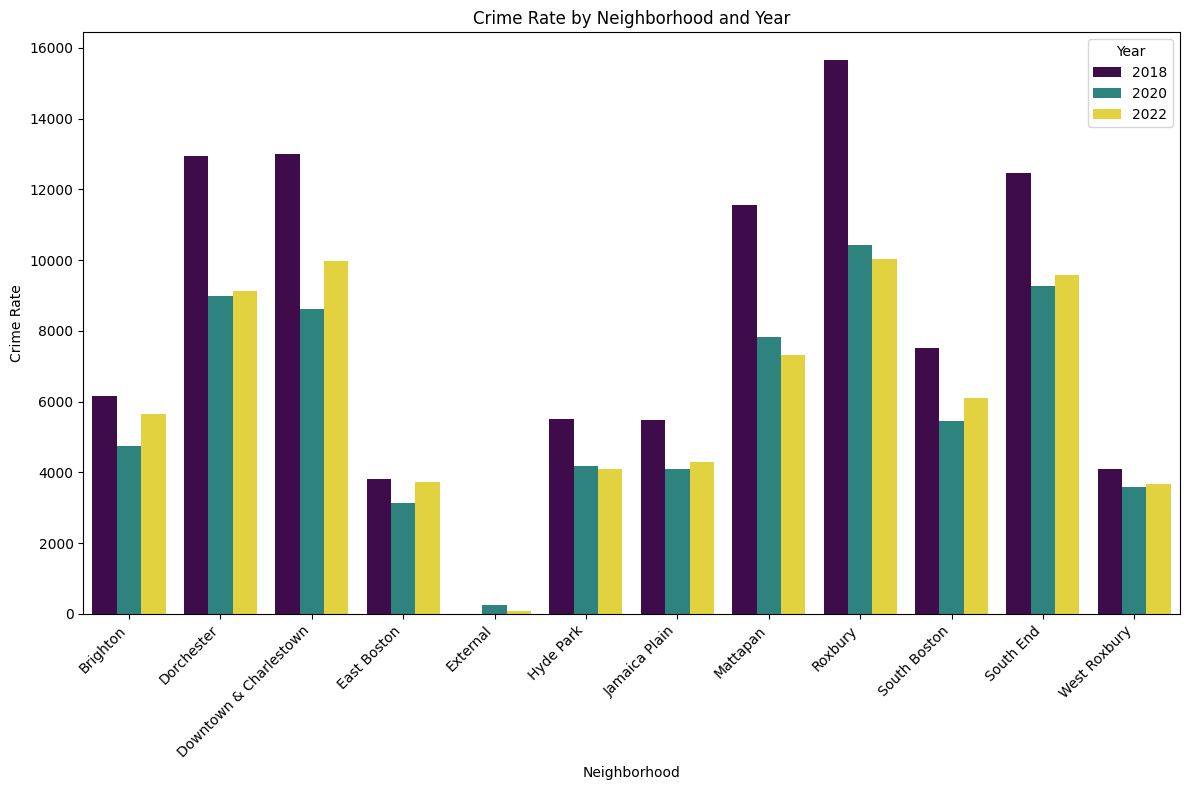

In [40]:
district_yearly_counts.drop(columns=["Trend"], inplace=True)
plot_data = district_yearly_counts.reset_index().melt(id_vars=['DISTRICT'], 
                                                      var_name='Year', 
                                                      value_name='Crime_Rate')

plt.figure(figsize=(12, 8))
sns.barplot(x='DISTRICT', y='Crime_Rate', hue='Year', data=plot_data, palette="viridis")

# Customize the plot
plt.xticks(rotation=45, ha='right')
plt.xlabel('Neighborhood')
plt.ylabel('Crime Rate')
plt.title('Crime Rate by Neighborhood and Year')
plt.legend(title='Year')
plt.tight_layout()

# Show the plot
plt.show()

Index(['PROPERTY_CRIME', 'SHOOTING', 'VIOLENT_CRIME'], dtype='object', name='CRIME_TYPE')


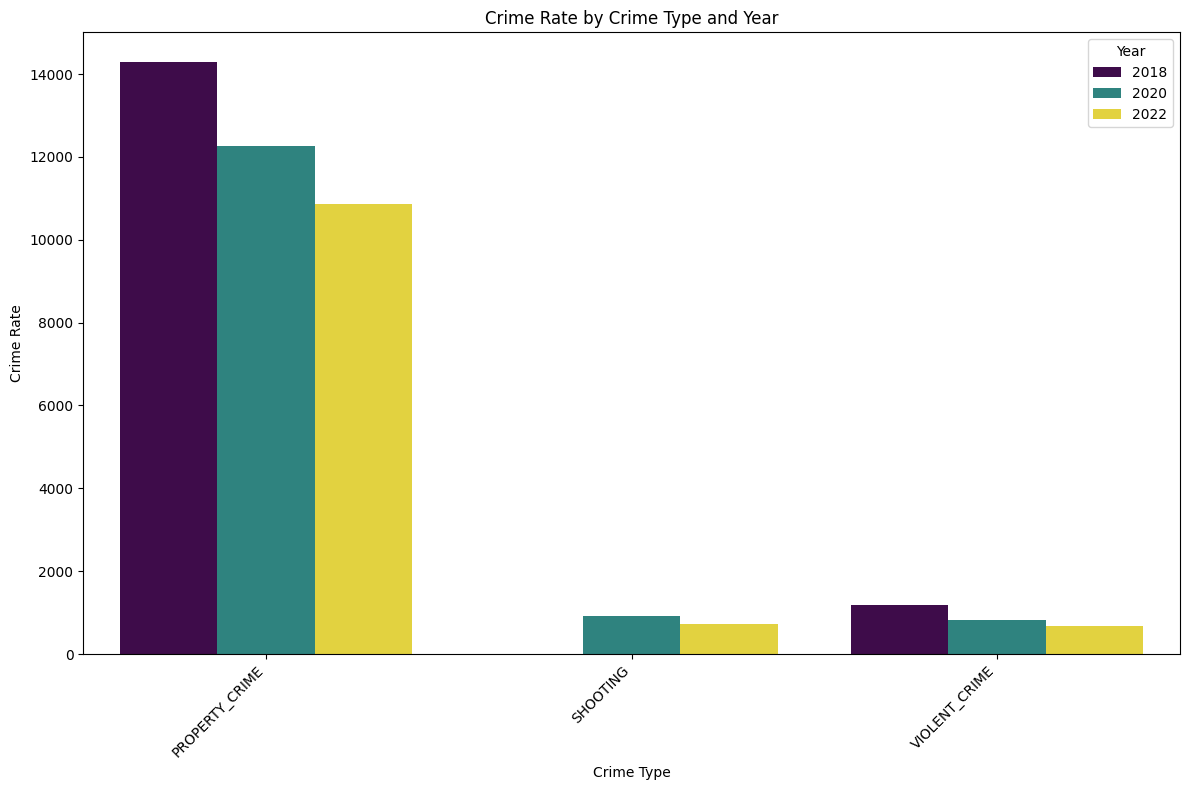

In [73]:
property_crimes = ['BURGLARY', 'LARCENY', 'AUTO THEFT', 'ARSON']
violent_crimes = ['HOMICIDE', 'ROBBERY', 'AGGRAVATED ASSAULT', 'RAPE']
df['CRIME_TYPE'] = df.apply(lambda x: 'VIOLENT_CRIME' if any(x['OFFENSE_DESCRIPTION'].upper().startswith(crime) for crime in violent_crimes) else "PROPERTY_CRIME" if any(x['OFFENSE_DESCRIPTION'].upper().startswith(crime) for crime in property_crimes) else 'SHOOTING' if x['SHOOTING'] == 1 else 'OTHER', axis=1)


crime_type_yearly_counts = df.groupby(['CRIME_TYPE', 'YEAR']).size().unstack(fill_value=0)
crime_type_yearly_counts.drop(index='OTHER', inplace=True)
print(crime_type_yearly_counts.index)
plot_data = crime_type_yearly_counts.reset_index().melt(id_vars=['CRIME_TYPE'], 
                                                      var_name='Year', 
                                                      value_name='Crime_Rate')

plt.figure(figsize=(12, 8))
sns.barplot(x='CRIME_TYPE', y='Crime_Rate', hue='Year', data=plot_data, palette="viridis")

# Customize the plot
plt.xticks(rotation=45, ha='right')
plt.xlabel('Crime Type')
plt.ylabel('Crime Rate')
plt.title('Crime Rate by Crime Type and Year')
plt.legend(title='Year')
plt.tight_layout()

# Show the plot
plt.show()

In [110]:
crime_type_district_yearly_counts = df[df['CRIME_TYPE'] != 'OTHER'].groupby(['DISTRICT', 'CRIME_TYPE']).size().unstack(fill_value=0)

crime_type_district_yearly_counts
# plot_data = crime_type_district_yearly_counts.reset_index().melt(id_vars=['DISTRICT'], 
#                                                       var_name='CRIME_TYPE', 
#                                                       value_name='Crime_Type_Rate')
# plt.figure(figsize=(12, 8))
# sns.barplot(x='DISTRICT', y='Crime_Type_Rate', hue='CRIME_TYPE', data=plot_data, palette="viridis")

# # Customize the plot
# plt.xticks(rotation=45, ha='right')
# plt.xlabel('District')
# plt.ylabel('Crime Rate')
# plt.title('Crime Rate by Crime Type and Neighborhood')
# plt.legend(title='Crime Type')
# plt.tight_layout()

# # Show the plot
# plt.show()

KeyError: 'CRIME_TYPE'

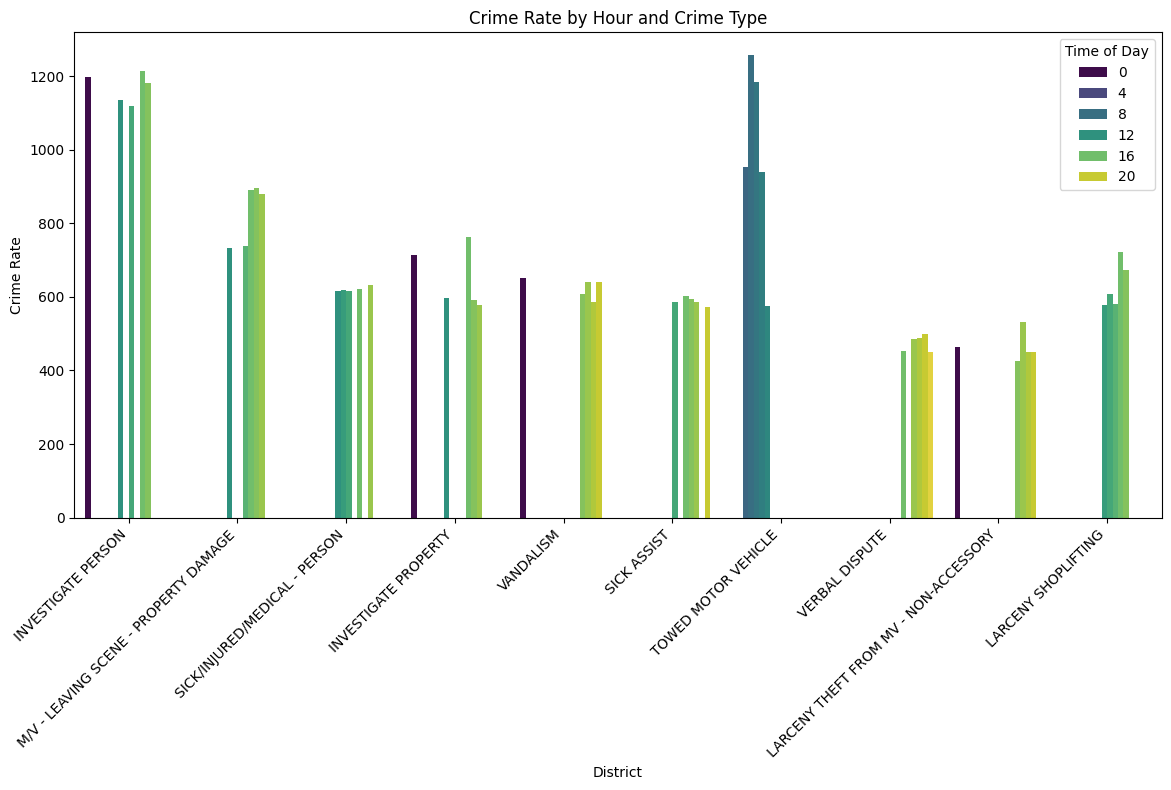

In [162]:
crime_type_hour_counts = df.groupby(['OFFENSE_DESCRIPTION', 'HOUR']).size().unstack(fill_value=0)
crime_type_total_counts = df.groupby(['OFFENSE_DESCRIPTION']).size().reset_index(name='Total')
top_crime_type = crime_type_total_counts.set_index('OFFENSE_DESCRIPTION')
top_crime_type = top_crime_type.sort_values(by='Total', ascending=False).head(10)
top_crime_type.index

crime_type_hour_counts = crime_type_hour_counts.reset_index().melt(id_vars=['OFFENSE_DESCRIPTION'], 
                                            var_name='HOUR', 
                                            value_name='Hour_Wise_Crime_Rate')
top_hour_per_crime = []
for crime in top_crime_type.index:
    top_hours = crime_type_hour_counts[crime_type_hour_counts['OFFENSE_DESCRIPTION'] == crime].nlargest(5, 'Hour_Wise_Crime_Rate')
    top_hour_per_crime.append(top_hours)

plot_data = pd.concat(top_hour_per_crime, ignore_index=True)
plot_data.set_index('OFFENSE_DESCRIPTION', inplace=True)
plot_data
plt.figure(figsize=(12, 8))
sns.barplot(x='OFFENSE_DESCRIPTION', y='Hour_Wise_Crime_Rate', hue='HOUR', data=plot_data, palette="viridis")

# Customize the plot
plt.xticks(rotation=45, ha='right')
plt.xlabel('District')
plt.ylabel('Crime Rate')
plt.title('Crime Rate by Hour and Crime Type')
plt.legend(title='Time of Day')
plt.tight_layout()

# Show the plot
plt.show()

                       HOUR  Hour_Wise_Crime_Rate
DISTRICT                                         
Roxbury                  17                  2283
Roxbury                  16                  2278
Roxbury                  18                  2199
Roxbury                  12                  2168
Roxbury                   0                  2162
Downtown & Charlestown    0                  2091
Downtown & Charlestown   17                  2075
Downtown & Charlestown   12                  2052
Downtown & Charlestown   16                  1963
Downtown & Charlestown   18                  1876
South End                16                  2046
South End                17                  2030
South End                12                  2013
South End                14                  1902
South End                13                  1892
Dorchester                0                  2436
Dorchester               18                  1994
Dorchester               17                  1890


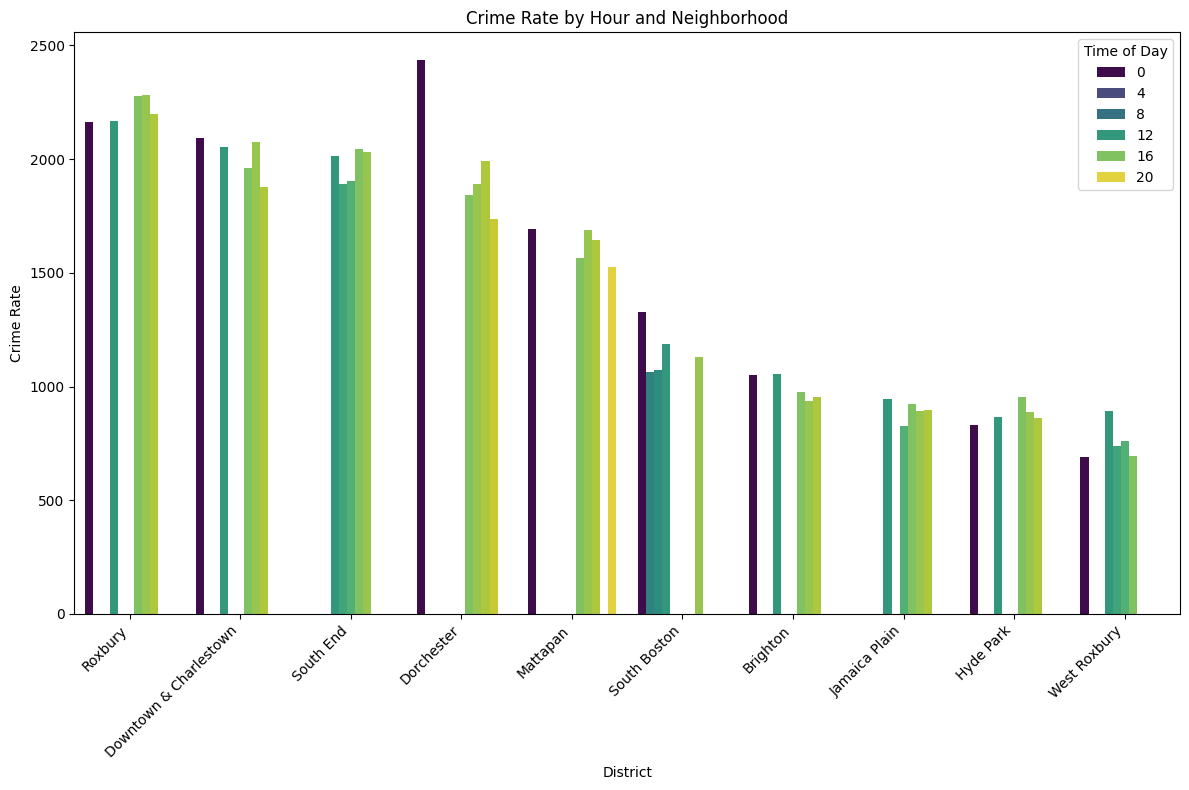

In [163]:
crime_type_hour_counts = df.groupby(['DISTRICT', 'HOUR']).size().unstack(fill_value=0)
crime_type_total_counts = df.groupby(['DISTRICT']).size().reset_index(name='Total')
top_crime_type = crime_type_total_counts.set_index('DISTRICT')
top_crime_type = top_crime_type.sort_values(by='Total', ascending=False).head(10)
top_crime_type.index

crime_type_hour_counts = crime_type_hour_counts.reset_index().melt(id_vars=['DISTRICT'], 
                                            var_name='HOUR', 
                                            value_name='Hour_Wise_Crime_Rate')
top_hour_per_crime = []
for crime in top_crime_type.index:
    top_hours = crime_type_hour_counts[crime_type_hour_counts['DISTRICT'] == crime].nlargest(5, 'Hour_Wise_Crime_Rate')
    top_hour_per_crime.append(top_hours)

plot_data = pd.concat(top_hour_per_crime, ignore_index=True)
plot_data.set_index('DISTRICT', inplace=True)
print(plot_data)
print(plot_data.HOUR.unique())
# print(plot_data)
# print(plot_data)
plt.figure(figsize=(12, 8))
sns.barplot(x='DISTRICT', y='Hour_Wise_Crime_Rate', hue='HOUR', data=plot_data, palette="viridis")

# Customize the plot
plt.xticks(rotation=45, ha='right')
plt.xlabel('District')
plt.ylabel('Crime Rate')
plt.title('Crime Rate by Hour and Neighborhood')
plt.legend(title='Time of Day')
plt.tight_layout()

# Show the plot
plt.show()